# Convolutional Neural Networks

CNNs are the ideal solution to discover pattern in visual data.

## Binary Image Classification

Using the __partial__ [Food101](https://www.tensorflow.org/datasets/catalog/food101) dataset:

```
mkdir datasets && cd datasets
wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
unzip pizza_steak.zip && rm pizza_steak
```

```
tree -L 3
datasets
└── pizza_steak
    ├── test
    │   ├── pizza
    │   └── steak
    └── train
        ├── pizza
        └── steak
```

### Dependencies

In [1]:
import itertools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

2023-03-06 13:20:28.655998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Inspect the Data

In [2]:
# inspect data
training_data_dir = pathlib.Path("../datasets/pizza_steak/train")
testing_data_dir = pathlib.Path("../datasets/pizza_steak/test")
# create class names from sub dir names
class_names = np.array(sorted([item.name for item in training_data_dir.glob("*")]))

str(training_data_dir), str(testing_data_dir), str(class_names)
# ('../datasets/pizza_steak/train',
#  '../datasets/pizza_steak/test',
#  "['pizza' 'steak']")

('../datasets/pizza_steak/train',
 '../datasets/pizza_steak/test',
 "['pizza' 'steak']")

<tf.Tensor: shape=(382, 512, 3), dtype=float32, numpy=
array([[[0.8156863 , 0.7294118 , 0.87058824],
        [0.827451  , 0.73333335, 0.8666667 ],
        [0.8392157 , 0.73333335, 0.87058824],
        ...,
        [0.25882354, 0.27058825, 0.30588236],
        [0.25882354, 0.25490198, 0.2784314 ],
        [0.2509804 , 0.24313726, 0.2627451 ]],

       [[0.8156863 , 0.7294118 , 0.8784314 ],
        [0.81960785, 0.7254902 , 0.8666667 ],
        [0.8235294 , 0.7176471 , 0.85490197],
        ...,
        [0.2509804 , 0.2627451 , 0.29803923],
        [0.26666668, 0.2627451 , 0.28627452],
        [0.28235295, 0.27450982, 0.29411766]],

       [[0.8039216 , 0.72156864, 0.8745098 ],
        [0.79607844, 0.70980394, 0.85882354],
        [0.7921569 , 0.6901961 , 0.8352941 ],
        ...,
        [0.23137255, 0.24705882, 0.2901961 ],
        [0.2627451 , 0.2627451 , 0.29411766],
        [0.30588236, 0.3019608 , 0.3254902 ]],

       ...,

       [[0.75686276, 0.5254902 , 0.3529412 ],
        [0.75

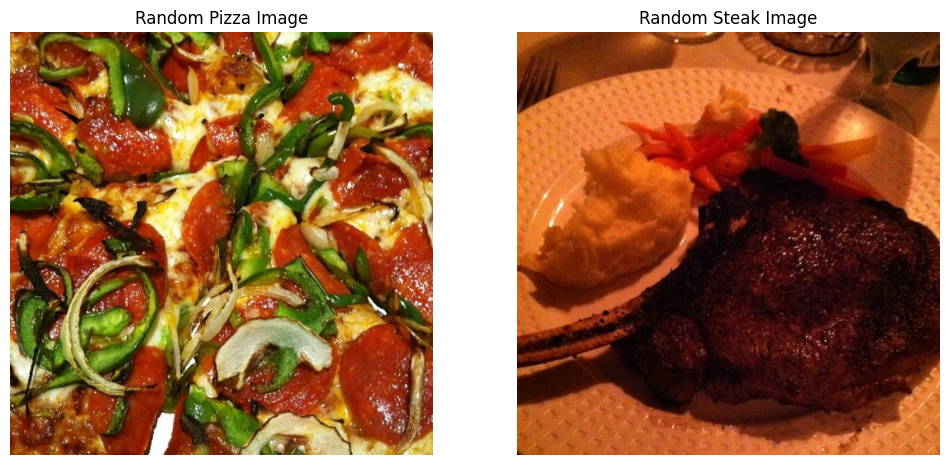

In [60]:
# display random images
def view_random_image(target_dir, target_class):
    target_folder = str(target_dir) + "/" + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(str(target_class) + str(img.shape))
    plt.axis("off")
    
    return tf.constant(img)

fig = plt.figure(figsize=(12, 12))
plot1 = fig.add_subplot(1, 2, 1)
pizza_image = view_random_image(target_dir = training_data_dir, target_class=class_names[0])
plot2 = fig.add_subplot(1, 2, 2)
steak_image = view_random_image(target_dir = training_data_dir, target_class=class_names[1])
plot1.title.set_text('Random Pizza Image')
plot2.title.set_text('Random Steak Image')

sample_image / 255

# the image is 512x384 pixels with 3 colour values per pixel
# to normalize the rgb values we need to divide all by 255

# <tf.Tensor: shape=(382, 512, 3), dtype=float32, numpy=
# array([[[0.8156863 , 0.7294118 , 0.87058824],
#         [0.827451  , 0.73333335, 0.8666667 ],
#         [0.8392157 , 0.73333335, 0.87058824],
#         ...,
#        [[0.75686276, 0.5254902 , 0.3529412 ],
#         [0.7411765 , 0.50980395, 0.3372549 ],
#         [0.7176471 , 0.4745098 , 0.3137255 ],
#         ...,
#         [0.59607846, 0.49803922, 0.38039216],
#         [0.6431373 , 0.5372549 , 0.42352942],
#         [0.65882355, 0.5529412 , 0.43529412]]], dtype=float32)>

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_01.png)

### Building the Model

In machine learning, a classifier assigns a class label to a data point. For example, an image classifier produces a class label (e.g, pizza, steak) for what objects exist within an image. A convolutional neural network, or __CNN__ for short, is a type of classifier, which excels at solving this problem.

<br/><br/>

#### Rebuilding the Tiny VGG Architecture

_(see [CNN Explainer](https://poloclub.github.io/cnn-explainer/))_

* __Preprocessing__:

```python
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs
)
```

* If labels is `inferred`", the directory should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored. "inferred" (labels are generated from the directory structure), None (no labels), or a list/tuple of integer labels of the same size as the number of image files found in the directory. Labels should be sorted according to the alphanumeric order of the image file paths
* String describing the encoding of labels. Options are:
  * `int`: means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
  * `categorical`: means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
  * `binary` means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).
  * `None` (no labels).

<br/><br/>

__Conv2D Layer Options__

* __Filters__: How many filters should be applied to the input tensor (`10`, `32`, `64`, `128`).
* __Kernel Size__: Sets the filter size.
* __Padding__: `same` pads target tensor with zeros to preserve input shape. `valid` lowers the output shape.
* __Strides__: `strides=1` moves the filter across an image 1 pixel at a time.

In [3]:
seed = 42
batch_size = 32
img_height = 224
img_width = 224

tf.random.set_seed(seed)

# train and test data dirs
train_dir = "../datasets/pizza_steak/train/"
test_dir = "../datasets/pizza_steak/test/"

training_data = image_dataset_from_directory(train_dir,
                                              labels='inferred',
                                              label_mode='binary',
                                              seed=seed,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)

testing_data = image_dataset_from_directory(test_dir,
                                              labels='inferred',
                                              label_mode='binary',
                                              seed=seed,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)

# building the model
cnn_model = Sequential([
  Rescaling(1./255),
  Conv2D(filters=10, 
         kernel_size=3,
         activation="relu", 
         input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2, padding="same"),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2),
  Flatten(),
  Dense(1, activation="sigmoid")
])

# compile the model
cnn_model.compile(loss="binary_crossentropy",
                 optimizer=Adam(learning_rate=1e-3),
                 metrics=["accuracy"])

# fitting the model
history_cnn = cnn_model.fit(training_data, epochs=5,
                            steps_per_epoch=len(training_data),
                            validation_data=testing_data,
                            validation_steps=len(testing_data))

# Found 1500 images belonging to 2 classes.
# Found 500 images belonging to 2 classes.
# Epoch 1/5

# Epoch 5/5
# 47/47 [==============================] - 2s 47ms/step - loss: 0.3347 - accuracy: 0.8540 - val_loss: 0.2927 - val_accuracy: 0.8820

Found 1500 files belonging to 2 classes.


2023-03-05 14:45:00.865293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 14:45:01.145099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 14:45:01.145275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-05 14:45:01.147269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

Found 500 files belonging to 2 classes.
Epoch 1/5


2023-03-05 14:45:09.217397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-05 14:45:11.474010: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2f2c7bbdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-05 14:45:11.474038: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-05 14:45:11.503971: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-05 14:45:11.512575: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-03-05 14:45:11.754060: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most o

47/47 [==============================] - 32s 459ms/step - loss: 0.5588 - accuracy: 0.7013 - val_loss: 0.4932 - val_accuracy: 0.7560
Epoch 2/5
47/47 [==============================] - 2s 48ms/step - loss: 0.4399 - accuracy: 0.8100 - val_loss: 0.4990 - val_accuracy: 0.7520
Epoch 3/5
47/47 [==============================] - 2s 48ms/step - loss: 0.4142 - accuracy: 0.8273 - val_loss: 0.3402 - val_accuracy: 0.8620
Epoch 4/5
47/47 [==============================] - 2s 48ms/step - loss: 0.3743 - accuracy: 0.8400 - val_loss: 0.3145 - val_accuracy: 0.8680
Epoch 5/5
47/47 [==============================] - 2s 48ms/step - loss: 0.3711 - accuracy: 0.8447 - val_loss: 0.3083 - val_accuracy: 0.8680


In [4]:
cnn_model.summary()

# Model: "sequential_8"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling (Rescaling)       (None, 224, 224, 3)       0 
#  conv2d_35 (Conv2D)          (None, 222, 222, 10)      280 
#  conv2d_36 (Conv2D)          (None, 220, 220, 10)      910 
#  max_pooling2d_17 (MaxPooling2D)  (None, 110, 110, 10) 0 
#  conv2d_37 (Conv2D)          (None, 108, 108, 10)      910 
#  conv2d_38 (Conv2D)          (None, 106, 106, 10)      910
#  max_pooling2d_18 (MaxPooling2D)  (None, 53, 53, 10)   0
#  flatten_8 (Flatten)         (None, 28090)             0
#  dense_8 (Dense)             (None, 1)                 28091 
# =================================================================
# Total params: 31,101
# Trainable params: 31,101
# Non-trainable params: 0
# _________________________________________________________________

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                        

### Building a Baseline Model

Above I already started with a CNN that was ideal for the given problem. Let's take a few steps back and try to work our way up to it by establishing a simple and fast baseline first. Fitting a machine learning model follows 3 steps:

1. Create a Baseline Model
2. Overfit a complexer model to improve the validation metric
  * Increase # of conv layers
  * Increas # of filters in conv layers
  * Add another dense layer above the output
3. Reduce the overfit
  * Add data augmentation
  * Add regularization layers (like pooling layers)
  * Add more, varied training data

In [5]:
tf.random.set_seed(42)

model_cnn_base = Sequential([
  Rescaling(1./255),
  Conv2D(filters=10,
          kernel_size=(3, 3),
          strides=(1, 1),
          padding="same",
          activation="relu",
          input_shape=(224, 224, 3),
          name="input_layer"),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  Flatten(),
  Dense(1, activation="sigmoid", name="output_layer")
])

model_cnn_base.compile(loss="binary_crossentropy",
                      optimizer=Adam(learning_rate=(1e-3)),
                      metrics=["accuracy"])

history_cnn_baseline = model_cnn_base.fit(training_data, epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

# Epoch 5/5
# 47/47 [==============================] - 3s 59ms/step - loss: 0.0901 - accuracy: 0.9740 - val_loss: 0.4827 - val_accuracy: 0.8020

Epoch 1/5
47/47 [==============================] - 6s 85ms/step - loss: 1.0942 - accuracy: 0.6293 - val_loss: 0.4278 - val_accuracy: 0.8220
Epoch 2/5
47/47 [==============================] - 3s 61ms/step - loss: 0.4420 - accuracy: 0.8120 - val_loss: 0.3740 - val_accuracy: 0.8480
Epoch 3/5
47/47 [==============================] - 3s 62ms/step - loss: 0.3471 - accuracy: 0.8653 - val_loss: 0.3609 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 3s 62ms/step - loss: 0.2874 - accuracy: 0.8873 - val_loss: 0.3669 - val_accuracy: 0.8380
Epoch 5/5
47/47 [==============================] - 3s 61ms/step - loss: 0.2594 - accuracy: 0.9047 - val_loss: 0.3608 - val_accuracy: 0.8400


#### Evaluating the Baseline Model

<AxesSubplot: title={'center': 'Baseline Model'}>

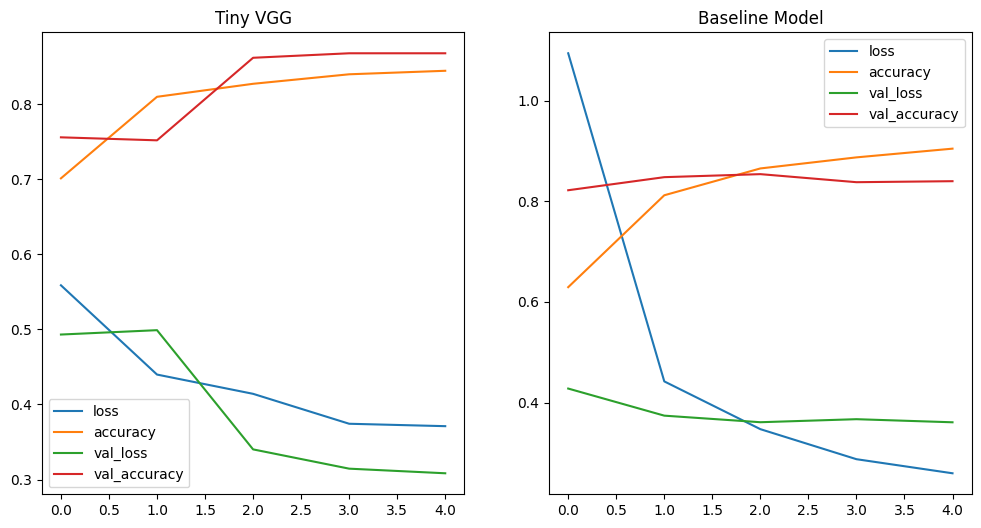

In [6]:
# print loss curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_cnn.history).plot(ax=axes[0], title="Tiny VGG")
pd.DataFrame(history_cnn_baseline.history).plot(ax=axes[1], title="Baseline Model")

# as pointed out above - we can see that the validation loss for the baseline model
# stops improving. But the loss on the trainings data keeps falling
# => this points to our model __overfitting__ the training dataset

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_02.png)

#### Reducing the Overfit

Improve the evaluation metrics by tackling the overfitting issue:

In [7]:
# adding pooling layers
# maxpool takes a square with size=poolsize (2 => 2x2)
# combines those pixel into 1 with the max value
# this looses fine details and directs your model
# towards the larger features in your image
model_cnn_base_pool = Sequential([
    Rescaling(1./255),
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 2, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 2, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_cnn_base_pool.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=1e-3),
                           metrics=["accuracy"])

history_cnn_baseline_pool = model_cnn_base_pool.fit(training_data, epochs=10,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

# Epoch 10/10
# 47/47 [==============================] - 1s 27ms/step - loss: 0.2748 - accuracy: 0.8907 - val_loss: 0.2552 - val_accuracy: 0.9040

Epoch 1/10
47/47 [==============================] - 3s 32ms/step - loss: 0.6439 - accuracy: 0.6280 - val_loss: 0.5003 - val_accuracy: 0.7440
Epoch 2/10
47/47 [==============================] - 1s 26ms/step - loss: 0.4811 - accuracy: 0.7740 - val_loss: 0.3949 - val_accuracy: 0.8380
Epoch 3/10
47/47 [==============================] - 1s 28ms/step - loss: 0.4220 - accuracy: 0.8047 - val_loss: 0.3618 - val_accuracy: 0.8560
Epoch 4/10
47/47 [==============================] - 1s 26ms/step - loss: 0.4016 - accuracy: 0.8133 - val_loss: 0.3437 - val_accuracy: 0.8740
Epoch 5/10
47/47 [==============================] - 1s 26ms/step - loss: 0.3732 - accuracy: 0.8380 - val_loss: 0.3074 - val_accuracy: 0.8820
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.3509 - accuracy: 0.8487 - val_loss: 0.4156 - val_accuracy: 0.7980
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.3517 - accuracy: 0.8480 - val_loss: 0.2926 - val_accuracy: 0.8920
Epoch 8/10
47

<AxesSubplot: title={'center': 'Pooled Baseline Model'}>

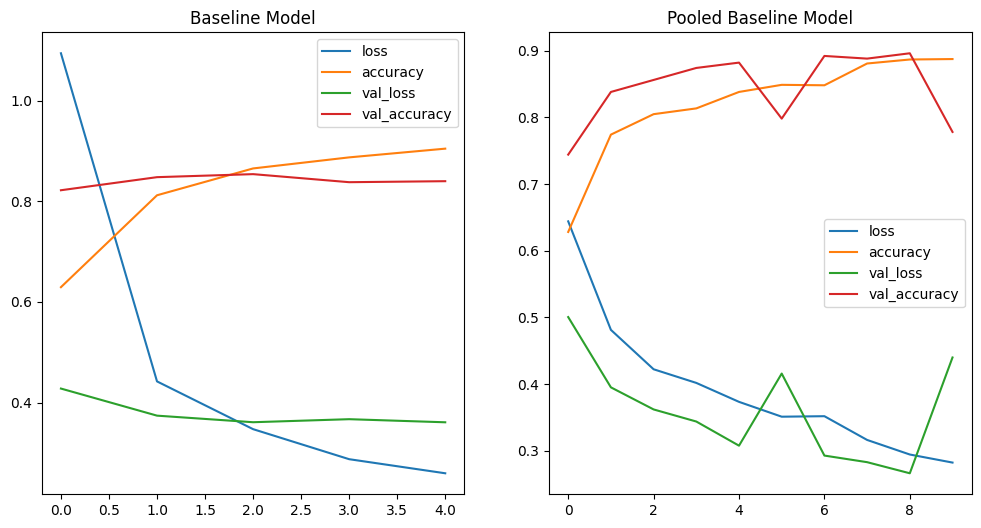

In [8]:
# print loss curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_cnn_baseline.history).plot(ax=axes[0], title="Baseline Model")
pd.DataFrame(history_cnn_baseline_pool.history).plot(ax=axes[1], title="Pooled Baseline Model")

# I increased the number of epochs to better see the result
# now it is obvious - adding pooling layers already solved the overfit

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_03.png)

Another tool we can use to improve the performance of an overfitting model is __Data Augmentation__.

In [11]:
# to further generalize we could add more images that add variations
# but we get a similar effect from just modifying our training images
# randomly using augmentations to increase diversity

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomBrightness(factor=0.2)
])

model_cnn_base_pool_aug = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 2, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 2, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_cnn_base_pool_aug.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=1e-3),
                           metrics=["accuracy"])

history_cnn_baseline_pool_aug = model_cnn_base_pool_aug.fit(training_data, epochs=50,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

# Epoch 50/50
# 47/47 [==============================] - 7s 145ms/step - loss: 0.3436 - accuracy: 0.8593 - val_loss: 0.2353 - val_accuracy: 0.9080

Epoch 1/50


47/47 [==============================] - 14s 152ms/step - loss: 0.6001 - accuracy: 0.6873 - val_loss: 0.5258 - val_accuracy: 0.7380
Epoch 2/50
47/47 [==============================] - 7s 149ms/step - loss: 0.5304 - accuracy: 0.7400 - val_loss: 0.4517 - val_accuracy: 0.8000
Epoch 3/50
47/47 [==============================] - 7s 146ms/step - loss: 0.4909 - accuracy: 0.7693 - val_loss: 0.4052 - val_accuracy: 0.8180
Epoch 4/50
47/47 [==============================] - 7s 146ms/step - loss: 0.4953 - accuracy: 0.7687 - val_loss: 0.4239 - val_accuracy: 0.8200
Epoch 5/50
47/47 [==============================] - 7s 148ms/step - loss: 0.4704 - accuracy: 0.7833 - val_loss: 0.3653 - val_accuracy: 0.8480
Epoch 6/50
47/47 [==============================] - 7s 147ms/step - loss: 0.4645 - accuracy: 0.7900 - val_loss: 0.3519 - val_accuracy: 0.8420
Epoch 7/50
47/47 [==============================] - 7s 152ms/step - loss: 0.4564 - accuracy: 0.7887 - val_loss: 0.3587 - val_accuracy: 0.8560
Epoch 8/50
47/47

47/47 [==============================] - 7s 142ms/step - loss: 0.3110 - accuracy: 0.8720 - val_loss: 0.2776 - val_accuracy: 0.8940
Epoch 49/50
47/47 [==============================] - 7s 147ms/step - loss: 0.3173 - accuracy: 0.8640 - val_loss: 0.2316 - val_accuracy: 0.9060
Epoch 50/50
47/47 [==============================] - 7s 145ms/step - loss: 0.3436 - accuracy: 0.8593 - val_loss: 0.2353 - val_accuracy: 0.9080


<AxesSubplot: title={'center': 'Augmented Baseline Model'}>

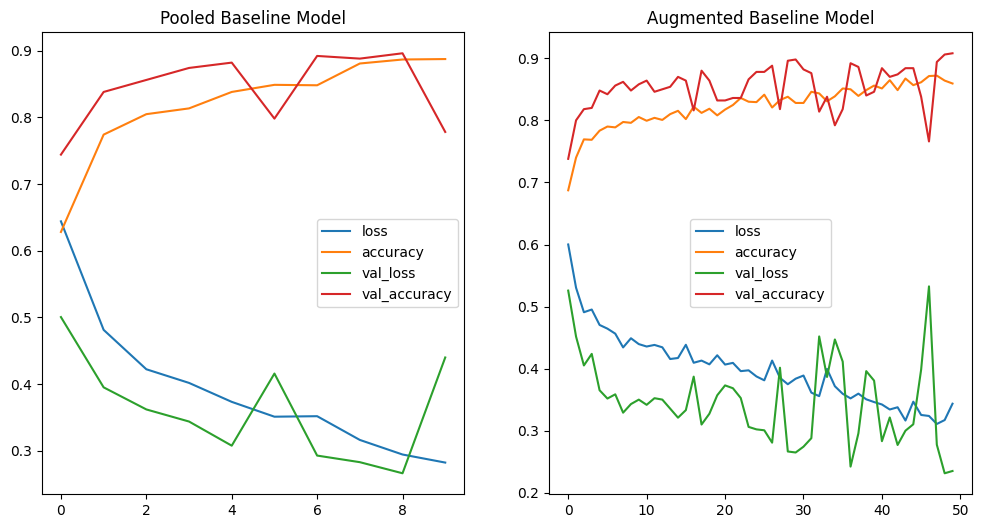

In [12]:
# print loss curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_cnn_baseline_pool.history).plot(ax=axes[0], title="Pooled Baseline Model")
pd.DataFrame(history_cnn_baseline_pool_aug.history).plot(ax=axes[1], title="Augmented Baseline Model")

# adding too many data augmentation can lead to a degradation of the performance of a model


![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_04.png)

Add shuffle to our datasets:

In [14]:
# randomize the order in which your models see the training images
# to remove biases in the order the data was collected in
seed = 42
batch_size = 32
img_height = 224
img_width = 224

tf.random.set_seed(seed)

# train and test data dirs
train_dir = "../datasets/pizza_steak/train/"
test_dir = "../datasets/pizza_steak/test/"

training_data_shuffled = image_dataset_from_directory(train_dir,
                                              labels='inferred',
                                              label_mode='binary',
                                              seed=seed,
                                              shuffle=True,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)

testing_data_shuffled = image_dataset_from_directory(test_dir,
                                              labels='inferred',
                                              label_mode='binary',
                                              seed=seed,
                                              shuffle=True,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)

# Found 1500 files belonging to 2 classes.
# Found 500 files belonging to 2 classes.

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [16]:
# re-run the same pooled and augmented model as before on shuffled data
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomBrightness(factor=0.2)
])

model_cnn_base_pool_aug_shuffle = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 2, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 2, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_cnn_base_pool_aug_shuffle.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=1e-3),
                           metrics=["accuracy"])

history_cnn_baseline_pool_aug_shuffle = model_cnn_base_pool_aug_shuffle.fit(training_data_shuffled, epochs=50,
                        steps_per_epoch=len(training_data_shuffled),
                        validation_data=testing_data_shuffled,
                        validation_steps=len(testing_data_shuffled))

# Epoch 50/50
# 47/47 [==============================] - 8s 160ms/step - loss: 0.3257 - accuracy: 0.8580 - val_loss: 0.2617 - val_accuracy: 0.8860

Epoch 1/50


47/47 [==============================] - 15s 163ms/step - loss: 0.6242 - accuracy: 0.6407 - val_loss: 0.5056 - val_accuracy: 0.7500
Epoch 2/50
47/47 [==============================] - 8s 157ms/step - loss: 0.5627 - accuracy: 0.7240 - val_loss: 0.4709 - val_accuracy: 0.8120
Epoch 3/50
47/47 [==============================] - 7s 156ms/step - loss: 0.5287 - accuracy: 0.7527 - val_loss: 0.4589 - val_accuracy: 0.7800
Epoch 4/50
47/47 [==============================] - 7s 149ms/step - loss: 0.5275 - accuracy: 0.7620 - val_loss: 0.4535 - val_accuracy: 0.7920
Epoch 5/50
47/47 [==============================] - 7s 147ms/step - loss: 0.5155 - accuracy: 0.7700 - val_loss: 0.4276 - val_accuracy: 0.8220
Epoch 6/50
47/47 [==============================] - 7s 145ms/step - loss: 0.5157 - accuracy: 0.7593 - val_loss: 0.4260 - val_accuracy: 0.8100
Epoch 7/50
47/47 [==============================] - 7s 152ms/step - loss: 0.4876 - accuracy: 0.7693 - val_loss: 0.4069 - val_accuracy: 0.8240
Epoch 8/50
47/47

47/47 [==============================] - 8s 166ms/step - loss: 0.3573 - accuracy: 0.8400 - val_loss: 0.3516 - val_accuracy: 0.8260
Epoch 49/50
47/47 [==============================] - 8s 160ms/step - loss: 0.3432 - accuracy: 0.8520 - val_loss: 0.2430 - val_accuracy: 0.9000
Epoch 50/50
47/47 [==============================] - 8s 160ms/step - loss: 0.3257 - accuracy: 0.8580 - val_loss: 0.2617 - val_accuracy: 0.8860


<AxesSubplot: title={'center': 'Augmented Baseline Model (Shuffled)'}>

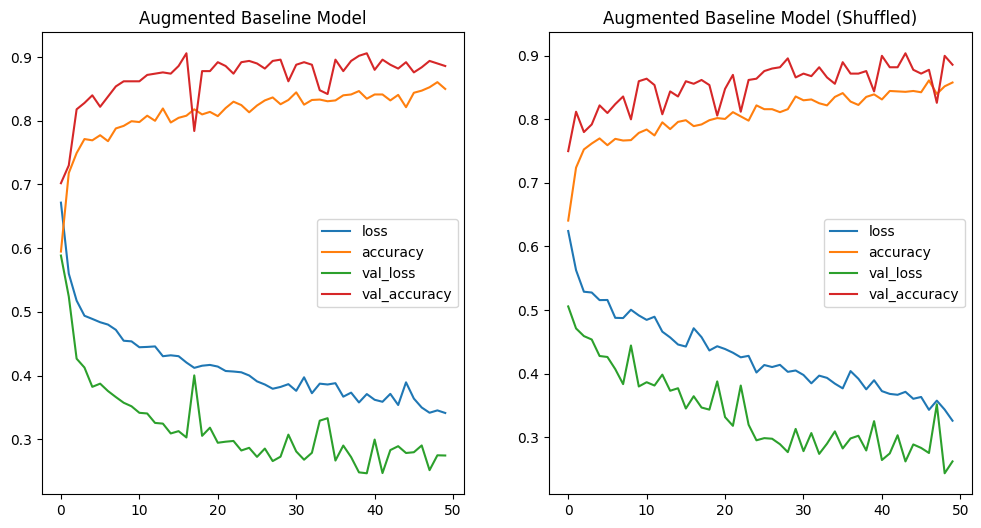

In [17]:
# print loss curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_cnn_baseline_pool_aug.history).plot(ax=axes[0], title="Augmented Baseline Model")
pd.DataFrame(history_cnn_baseline_pool_aug_shuffle.history).plot(ax=axes[1], title="Augmented Baseline Model (Shuffled)")

# the shuffled data shows a much steeper descent in the loss value:

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_05.png)

<AxesSubplot: title={'center': 'Augmented Baseline Model (Shuffled)'}>

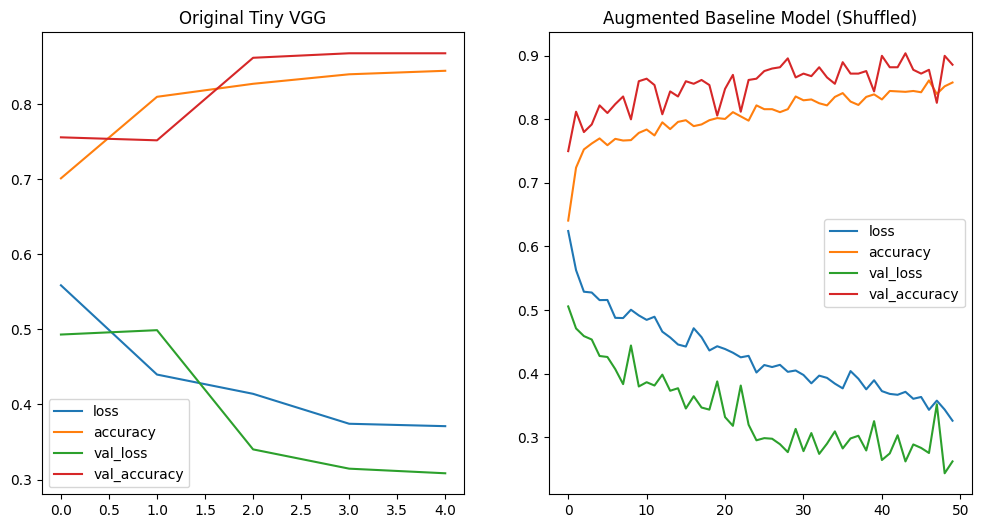

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_cnn.history).plot(ax=axes[0], title="Original Tiny VGG")
pd.DataFrame(history_cnn_baseline_pool_aug_shuffle.history).plot(ax=axes[1], title="Augmented Baseline Model (Shuffled)")

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_06.png)

Now that I have the data preprocessing dialed and am getting similar results to the initial __Tiny VGG__ run I want to see how this model performce now with the optimized data:

In [19]:
# re-run the augmented data through the Tiny VGG architecture model
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomBrightness(factor=0.2)
])

vgg_model = Sequential([
  data_augmentation,
  Rescaling(1./255),
  Conv2D(filters=10, 
         kernel_size=3,
         activation="relu", 
         input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2, padding="same"),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2),
  Flatten(),
  Dense(1, activation="sigmoid")
])

vgg_model.compile(loss="binary_crossentropy",
                           optimizer=Adam(learning_rate=1e-3),
                           metrics=["accuracy"])

history_vgg_model = vgg_model.fit(training_data_shuffled, epochs=50,
                        steps_per_epoch=len(training_data_shuffled),
                        validation_data=testing_data_shuffled,
                        validation_steps=len(testing_data_shuffled))

# Epoch 50/50
# 47/47 [==============================] - 8s 175ms/step - loss: 0.2746 - accuracy: 0.8927 - val_loss: 0.2192 - val_accuracy: 0.9200

Epoch 1/50


47/47 [==============================] - 15s 177ms/step - loss: 0.6611 - accuracy: 0.6407 - val_loss: 0.5035 - val_accuracy: 0.8200
Epoch 2/50
47/47 [==============================] - 8s 176ms/step - loss: 0.5340 - accuracy: 0.7433 - val_loss: 0.4503 - val_accuracy: 0.8240
Epoch 3/50
47/47 [==============================] - 9s 179ms/step - loss: 0.5062 - accuracy: 0.7673 - val_loss: 0.4683 - val_accuracy: 0.8000
Epoch 4/50
47/47 [==============================] - 9s 181ms/step - loss: 0.5006 - accuracy: 0.7687 - val_loss: 0.4011 - val_accuracy: 0.8540
Epoch 5/50
47/47 [==============================] - 9s 184ms/step - loss: 0.4738 - accuracy: 0.7800 - val_loss: 0.3924 - val_accuracy: 0.8340
Epoch 6/50
47/47 [==============================] - 9s 191ms/step - loss: 0.4786 - accuracy: 0.7847 - val_loss: 0.4131 - val_accuracy: 0.8100
Epoch 7/50
47/47 [==============================] - 9s 181ms/step - loss: 0.5002 - accuracy: 0.7693 - val_loss: 0.3874 - val_accuracy: 0.8540
Epoch 8/50
47/47

47/47 [==============================] - 9s 178ms/step - loss: 0.2921 - accuracy: 0.8773 - val_loss: 0.2623 - val_accuracy: 0.8940
Epoch 49/50
47/47 [==============================] - 9s 181ms/step - loss: 0.3064 - accuracy: 0.8733 - val_loss: 0.2108 - val_accuracy: 0.9160
Epoch 50/50
47/47 [==============================] - 8s 175ms/step - loss: 0.2746 - accuracy: 0.8927 - val_loss: 0.2192 - val_accuracy: 0.9200


<AxesSubplot: title={'center': 'Tiny VGG with Augumented Data'}>

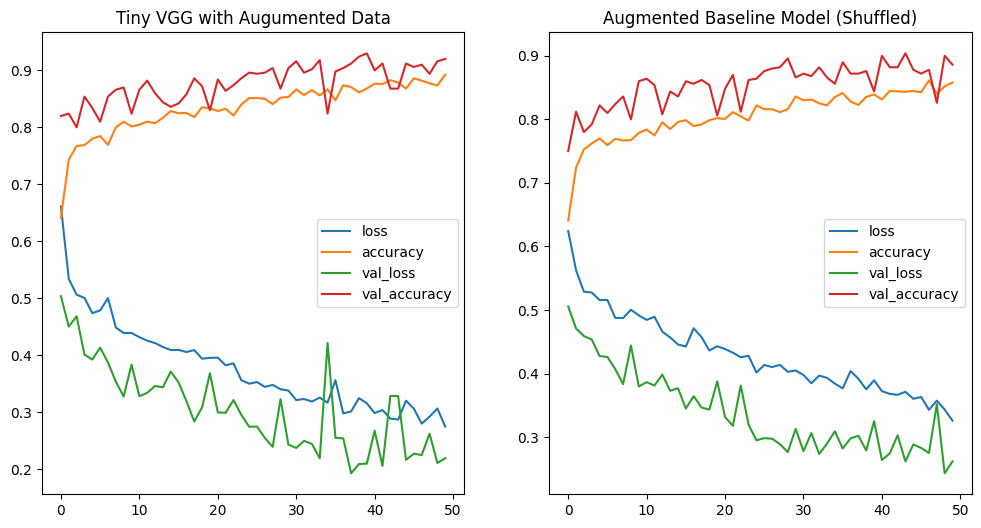

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_cnn_baseline_pool_aug_shuffle.history).plot(ax=axes[1], title="Augmented Baseline Model (Shuffled)")
pd.DataFrame(history_vgg_model.history).plot(ax=axes[0], title="Tiny VGG with Augumented Data")

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_07.png)

### Making Predictions on Custom Data

Now that I have a model that looks like it is performing well I can try to run a prediction on a personal picture from my favorite pizza place on the beach of Koh Rong in Cambodia:

![Convolutional Neural Networks](../assets/pizza.jpg)

In [18]:
pizza_path = "../assets/pizza.jpg"
pizza_img = mpimg.imread(pizza_path)
pizza_img.shape
# (426, 640, 3)
# before passing the image to our model we first need to pre-process it the same
# way we processed our training images.

steak_path = "../assets/steak.jpg"

In [19]:
# helper function to pre-process images for predictions
def prepare_image(file_name, im_shape=224):
    # read in image
    img = tf.io.read_file(file_name)
    # image array => tensor
    img = tf.image.decode_image(img)
    # reshape to training size
    img = tf.image.resize(img, size=[im_shape, im_shape])
    # we don't need to normalize the image this is done by the model itself
    # img = img/255
    # add a dimension in front for batch size => shape=(1, 224, 224, 3)
    img = tf.expand_dims(img, axis=0)
    return img

In [81]:
test_image_steak = prepare_image(file_name=steak_path)
test_image_pizza = prepare_image(file_name=pizza_path)
test_image_pizza
# the image now has the right shape to be ingested by our model:
# <tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
# array([[[[136.07143  , 141.07143  , 111.07143  ],
#          ...

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[136.07143  , 141.07143  , 111.07143  ],
         [134.       , 137.42857  , 106.21429  ],
         [128.07143  , 129.07143  ,  97.07143  ],
         ...,
         [104.165245 , 137.16525  , 182.16525  ],
         [106.665184 , 139.66519  , 184.66519  ],
         [108.307945 , 141.30795  , 186.30795  ]],

        [[137.4241   , 142.4241   , 112.4241   ],
         [134.       , 138.21428  , 105.42857  ],
         [128.07143  , 129.07143  ,  97.07143  ],
         ...,
         [108.06254  , 141.06253  , 186.06253  ],
         [109.919655 , 142.91965  , 187.91965  ],
         [109.760376 , 142.76038  , 187.76038  ]],

        [[138.39732  , 143.39732  , 113.39732  ],
         [134.41422  , 138.62851  , 105.8428   ],
         [129.48947  , 130.48947  ,  96.48948  ],
         ...,
         [111.13239  , 144.1324   , 187.1324   ],
         [112.46876  , 145.46877  , 190.46877  ],
         [108.69592  , 141.69592  , 186.69592 

In [82]:
prediction_pizza = vgg_model.predict(test_image_pizza)
prediction_pizza
# we receive a prediction probability of `~0.86`
# array([[0.02831189]], dtype=float32)

1/1 [==============================] - 0s 15ms/step


array([[0.02831189]], dtype=float32)

In [83]:
# make the propability output "readable"
pred_class_pizza = class_names[int(tf.round(prediction_pizza))]
pred_class_pizza
# 'pizza'

'pizza'

In [84]:
prediction_steak = vgg_model.predict(test_image_steak)
pred_class_steak = class_names[int(tf.round(prediction_steak))]
pred_class_steak
# 'steak'

1/1 [==============================] - 0s 16ms/step


'steak'

In [20]:
# making the process a bit more visually appealing
def predict_and_plot(model, file_name, class_names):
    # load the image and preprocess
    img = prepare_image(file_name)
    # run prediction
    prediction = model.predict(img)
    # get predicted class name
    pred_class = class_names[int(tf.round(prediction))]
    # plot image & prediction
    plt.imshow(mpimg.imread(file_name))
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 0s 16ms/step


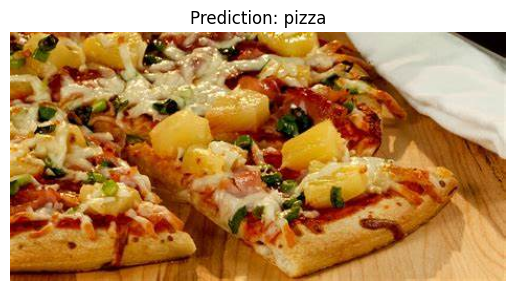

In [92]:
# a few more images to test with
pizza_path2 = "../assets/pizza2.jpg"
pizza_path3 = "../assets/pizza3.jpg"
steak_path2 = "../assets/steak2.jpg"
steak_path3 = "../assets/steak3.jpg"

predict_and_plot(model=vgg_model, file_name=pizza_path3, class_names=class_names)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_08.png)

![Convolutional Neural Networks](../assets/nice.gif)

## Multiclass Image Classification

* cd datasets
* wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
* unzip 10_food_classes_all_data.zip && rm 10_food_classes_all_data.zip


```
10_food_classes_all_data
├── test
│   ├── chicken_curry
│   ├── chicken_wings
│   ├── fried_rice
│   ├── grilled_salmon
│   ├── hamburger
│   ├── ice_cream
│   ├── pizza
│   ├── ramen
│   ├── steak
│   └── sushi
└── train
    ├── chicken_curry
    ├── chicken_wings
    ├── fried_rice
    ├── grilled_salmon
    ├── hamburger
    ├── ice_cream
    ├── pizza
    ├── ramen
    ├── steak
    └── sushi

23 directories, 0 files
```


### Visualizing the Data

In [2]:
# set directories
training_directory = "../datasets/10_food_classes_all_data/train/"
testing_directory = "../datasets/10_food_classes_all_data/test/"

# get class names
data_dir = pathlib.Path(training_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
len(class_names), class_names 

# the data set has 10 classes:
# (10,
# array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
#        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
#       dtype='<U14'))

(10,
 array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
       dtype='<U14'))

2023-03-06 13:20:46.833795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 13:20:47.095983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 13:20:47.096343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 13:20:47.098664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

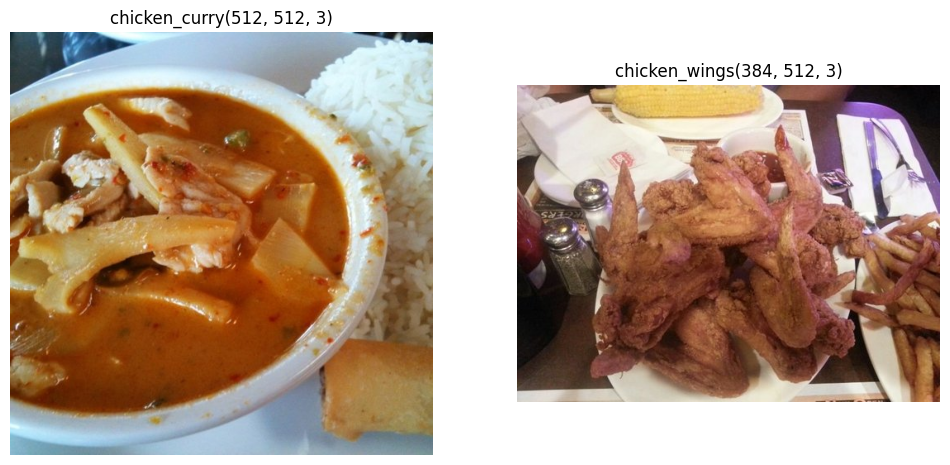

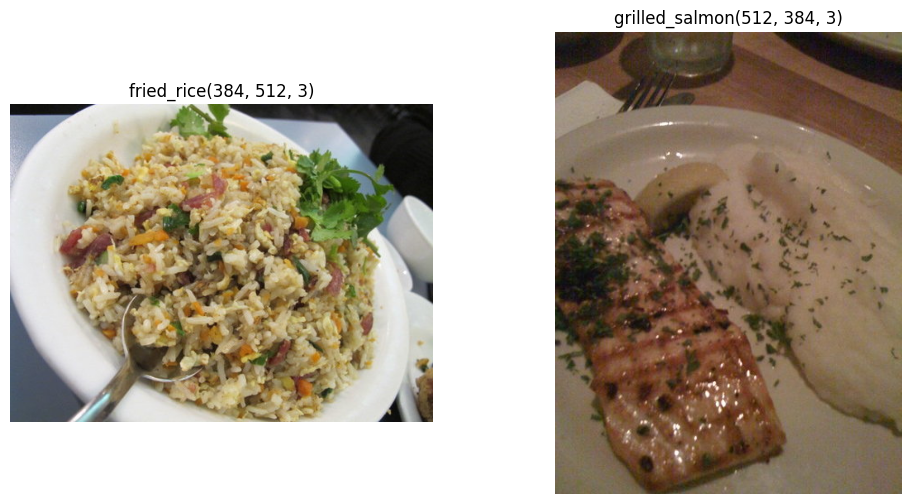

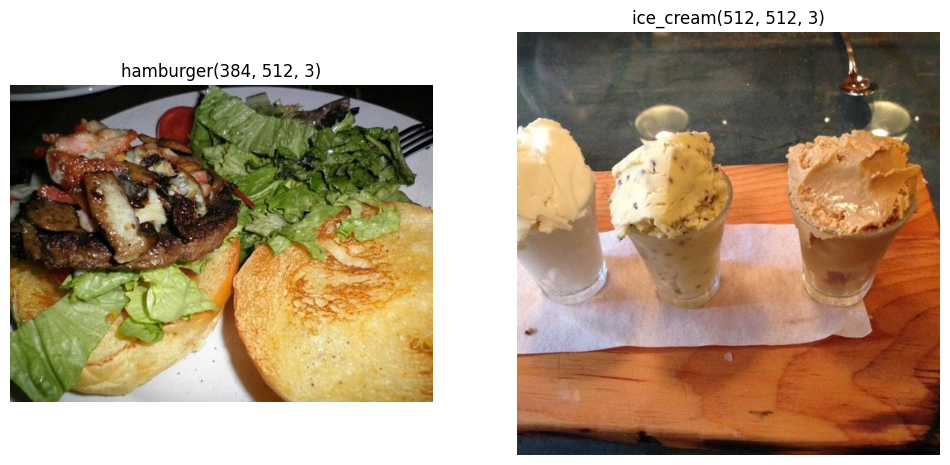

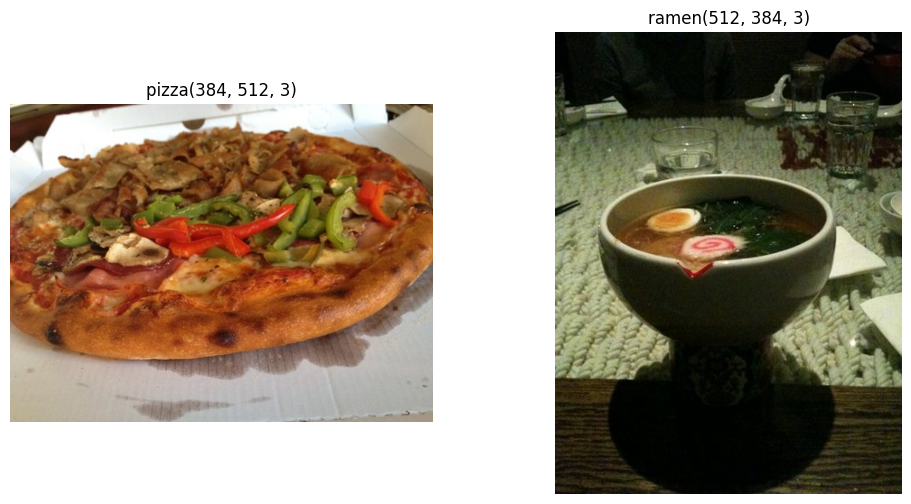

In [3]:
# visualizing the dataset
## display random images
def view_random_image(target_dir, target_class):
    target_folder = str(target_dir) + "/" + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(str(target_class) + str(img.shape))
    plt.axis("off")
    
    return tf.constant(img)

fig = plt.figure(figsize=(12, 6))
plot1 = fig.add_subplot(1, 2, 1)
plot1.title.set_text(f'Class: {class_names[0]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[0])
plot2 = fig.add_subplot(1, 2, 2)
plot2.title.set_text(f'Class: {class_names[1]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[1])

fig = plt.figure(figsize=(12, 6))
plot3 = fig.add_subplot(1, 2, 1)
plot3.title.set_text(f'Class: {class_names[2]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[2])
plot4 = fig.add_subplot(1, 2, 2)
plot4.title.set_text(f'Class: {class_names[3]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[3])

fig = plt.figure(figsize=(12, 6))
plot5 = fig.add_subplot(1, 2, 1)
plot5.title.set_text(f'Class: {class_names[4]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[4])
plot6 = fig.add_subplot(1, 2, 2)
plot6.title.set_text(f'Class: {class_names[5]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[5])

fig = plt.figure(figsize=(12, 6))
plot7 = fig.add_subplot(1, 2, 1)
plot7.title.set_text(f'Class: {class_names[6]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[6])
plot8 = fig.add_subplot(1, 2, 2)
plot8.title.set_text(f'Class: {class_names[7]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[7])

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_09.png)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_10.png)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_11.png)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_12.png)

### Preprocessing the Data

In [11]:
seed = 42
batch_size = 32
img_height = 224
img_width = 224

tf.random.set_seed(seed)

training_data_multi = image_dataset_from_directory(training_directory,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=seed,
                                              shuffle=True,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)

testing_data_multi = image_dataset_from_directory(testing_directory,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=seed,
                                              shuffle=True,
                                              image_size=(img_height, img_width),
                                              batch_size=batch_size)
# Found 7500 files belonging to 10 classes.
# Found 2500 files belonging to 10 classes.

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Building the Model

In [8]:
tf.random.set_seed(seed)
# building the model based on the tiny vgg architecture
vgg_model_multiclass = Sequential([
  Rescaling(1./255),
  Conv2D(filters=10, 
         kernel_size=3,
         activation="relu", 
         input_shape=(img_height, img_width, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2, padding="valid"),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2, padding="valid"),
  Flatten(),
  Dense(len(class_names), activation="softmax")
])

# compile the model
vgg_model_multiclass.compile(loss="categorical_crossentropy",
                 optimizer=Adam(learning_rate=1e-3),
                 metrics=["accuracy"])

# fitting the model
history_vgg_model_multiclass = vgg_model_multiclass.fit(training_data_multi, epochs=5,
                            steps_per_epoch=len(training_data_multi),
                            validation_data=testing_data_multi,
                            validation_steps=len(testing_data_multi))

# Epoch 5/5
# 235/235 [==============================] - 12s 52ms/step - loss: 0.2465 - accuracy: 0.9251 - val_loss: 4.0673 - val_accuracy: 0.2760

Epoch 1/5
235/235 [==============================] - 15s 55ms/step - loss: 2.1085 - accuracy: 0.2301 - val_loss: 1.9638 - val_accuracy: 0.3184
Epoch 2/5
235/235 [==============================] - 12s 52ms/step - loss: 1.8761 - accuracy: 0.3499 - val_loss: 1.9459 - val_accuracy: 0.3344
Epoch 3/5
235/235 [==============================] - 12s 51ms/step - loss: 1.6985 - accuracy: 0.4319 - val_loss: 1.8518 - val_accuracy: 0.3620
Epoch 4/5
235/235 [==============================] - 12s 51ms/step - loss: 1.3941 - accuracy: 0.5392 - val_loss: 2.0235 - val_accuracy: 0.3292
Epoch 5/5
235/235 [==============================] - 13s 53ms/step - loss: 0.9272 - accuracy: 0.6955 - val_loss: 2.3842 - val_accuracy: 0.3136


<AxesSubplot: title={'center': 'Tiny VGG (Multiclass)'}>

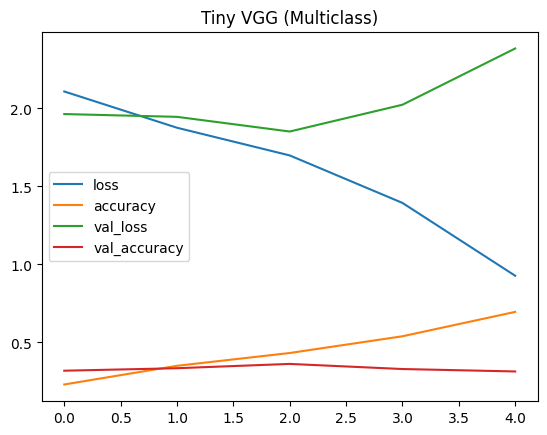

In [9]:
pd.DataFrame(history_vgg_model_multiclass.history).plot(title="Tiny VGG (Multiclass)")

# The training loss and accuracy are getting close to being perfect
# while the validation loss is running away => overfitting

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_13.png)

#### Reduce Overfitting

In [10]:
tf.random.set_seed(seed)
# reduce the complexity of our model to minimize the overfit
vgg_model_multiclass_simplified = Sequential([
  Rescaling(1./255),
  Conv2D(filters=10, 
         kernel_size=3,
         activation="relu", 
         input_shape=(img_height, img_width, 3)),
  MaxPool2D(pool_size=2, padding="valid"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2, padding="valid"),
  Flatten(),
  Dense(len(class_names), activation="softmax")
])

# compile the model
vgg_model_multiclass_simplified.compile(loss="categorical_crossentropy",
                 optimizer=Adam(learning_rate=1e-3),
                 metrics=["accuracy"])

# fitting the model
history_vgg_model_multiclass_simplified = vgg_model_multiclass_simplified.fit(
                            training_data_multi, epochs=5,
                            steps_per_epoch=len(training_data_multi),
                            validation_data=testing_data_multi,
                            validation_steps=len(testing_data_multi))

# Epoch 5/5
# 235/235 [==============================] - 12s 52ms/step - loss: 0.2465 - accuracy: 0.9251 - val_loss: 4.0673 - val_accuracy: 0.2760

Epoch 1/5
235/235 [==============================] - 8s 29ms/step - loss: 2.1472 - accuracy: 0.2304 - val_loss: 2.0183 - val_accuracy: 0.2984
Epoch 2/5
235/235 [==============================] - 7s 29ms/step - loss: 1.7461 - accuracy: 0.4144 - val_loss: 1.9464 - val_accuracy: 0.3208
Epoch 3/5
235/235 [==============================] - 7s 31ms/step - loss: 1.3335 - accuracy: 0.5641 - val_loss: 2.1159 - val_accuracy: 0.2976
Epoch 4/5
235/235 [==============================] - 7s 28ms/step - loss: 0.8979 - accuracy: 0.7168 - val_loss: 2.4371 - val_accuracy: 0.2880
Epoch 5/5
235/235 [==============================] - 7s 28ms/step - loss: 0.5149 - accuracy: 0.8484 - val_loss: 2.9666 - val_accuracy: 0.2764


<AxesSubplot: title={'center': 'Simple Tiny VGG (Multiclass)'}>

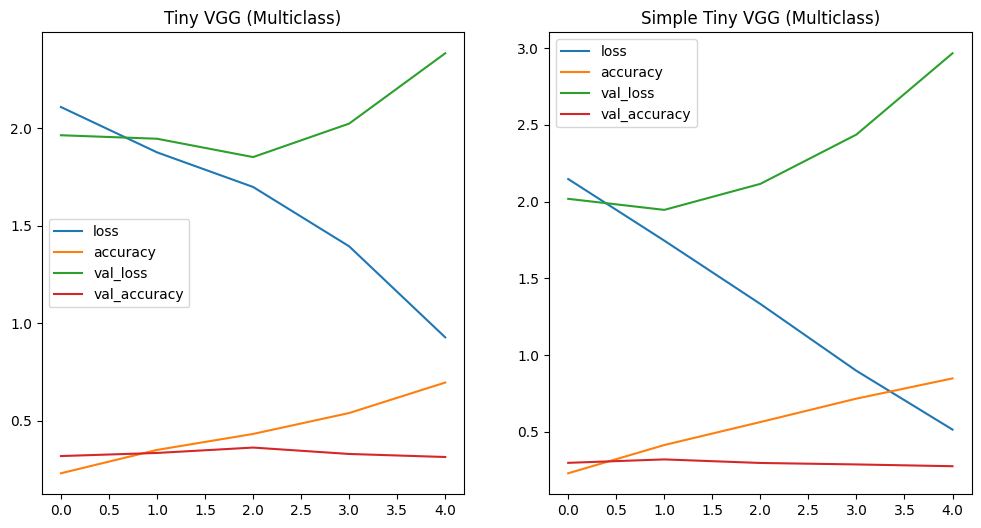

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_vgg_model_multiclass.history).plot(ax=axes[0], title="Tiny VGG (Multiclass)")
pd.DataFrame(history_vgg_model_multiclass_simplified.history).plot(ax=axes[1], title="Simple Tiny VGG (Multiclass)")
# that did not help at all...

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_14.png)

In [6]:
tf.random.set_seed(seed)
# adding data augmentations
# i experimented a little bit with this
# things can go horrible wrong if you
# add too much :)
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
#     RandomZoom(0.1),
#     RandomContrast(0.2),
#     RandomBrightness(0.2)
])

# building the model
vgg_model_multiclass_augmentation = Sequential([
  data_augmentation,
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2, padding="same"),
  Conv2D(16, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(2, padding="same"),
  Flatten(),
  Dense(len(class_names), activation="softmax")
])

# compile the model
vgg_model_multiclass_augmentation.compile(loss="categorical_crossentropy",
                 optimizer=Adam(learning_rate=1e-3),
                 metrics=["accuracy"])

# fitting the model
history_vgg_model_multiclass_augmentation = vgg_model_multiclass_augmentation.fit(
                            training_data_multi, epochs=25,
                            steps_per_epoch=len(training_data_multi),
                            validation_data=testing_data_multi,
                            validation_steps=len(testing_data_multi))

# Epoch 10/10
# 235/235 [==============================] - 23s 99ms/step - loss: 1.6899 - accuracy: 0.4245 - val_loss: 1.8349 - val_accuracy: 0.3736

Epoch 1/25


2023-03-06 13:21:44.382002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-06 13:21:46.742249: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5580a4f19280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-06 13:21:46.742273: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-06 13:21:46.773981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-06 13:21:46.782881: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-03-06 13:21:47.119123: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most o

235/235 [==============================] - 129s 495ms/step - loss: 2.1464 - accuracy: 0.2199 - val_loss: 1.9822 - val_accuracy: 0.2796
Epoch 2/25
235/235 [==============================] - 20s 86ms/step - loss: 1.9927 - accuracy: 0.2916 - val_loss: 1.9331 - val_accuracy: 0.3004
Epoch 3/25
235/235 [==============================] - 20s 85ms/step - loss: 1.9568 - accuracy: 0.3067 - val_loss: 1.8740 - val_accuracy: 0.3328
Epoch 4/25
235/235 [==============================] - 20s 85ms/step - loss: 1.9083 - accuracy: 0.3357 - val_loss: 1.8534 - val_accuracy: 0.3576
Epoch 5/25
235/235 [==============================] - 21s 88ms/step - loss: 1.8505 - accuracy: 0.3669 - val_loss: 1.7627 - val_accuracy: 0.3920
Epoch 6/25
235/235 [==============================] - 21s 89ms/step - loss: 1.8111 - accuracy: 0.3813 - val_loss: 1.7816 - val_accuracy: 0.3912
Epoch 7/25
235/235 [==============================] - 21s 89ms/step - loss: 1.8006 - accuracy: 0.3856 - val_loss: 1.7397 - val_accuracy: 0.4048
E

<AxesSubplot: title={'center': 'Augmented Tiny VGG (Multiclass)'}>

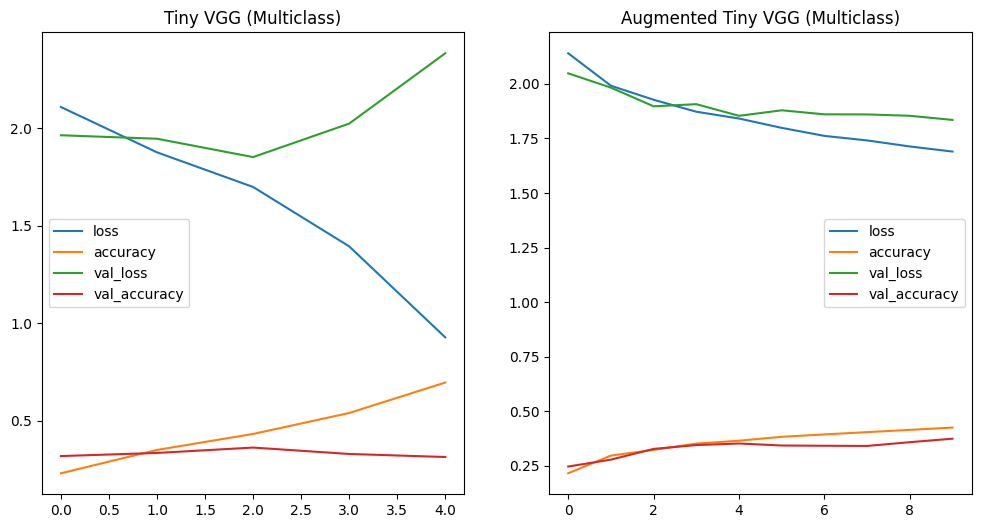

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_vgg_model_multiclass.history).plot(ax=axes[0], title="Tiny VGG (Multiclass)")
pd.DataFrame(history_vgg_model_multiclass_augmentation.history).plot(ax=axes[1], title="Augmented Tiny VGG (Multiclass)")
# this looks already alot better - but the improvement is very slow...

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_15.png)

In [14]:
# try adding a few more epochs to get those curves closer
history_vgg_model_multiclass_augmentation = vgg_model_multiclass_augmentation.fit(
                            training_data_multi, epochs=25,
                            steps_per_epoch=len(training_data_multi),
                            validation_data=testing_data_multi,
                            validation_steps=len(testing_data_multi))

# as expected - running the training for longer - slowly - improves the accuracy
# as well as validation accuracy for the model. The validation loss, however, remains
# stubbornly high:
# Epoch 25/25
# 235/235 [==============================] - 23s 97ms/step - loss: 1.3810 - accuracy: 0.5397 - val_loss: 1.7875 - val_accuracy: 0.4048

Epoch 1/25
235/235 [==============================] - 24s 100ms/step - loss: 1.6818 - accuracy: 0.4297 - val_loss: 1.8900 - val_accuracy: 0.3352
Epoch 2/25
235/235 [==============================] - 24s 100ms/step - loss: 1.6435 - accuracy: 0.4392 - val_loss: 1.8520 - val_accuracy: 0.3736
Epoch 3/25
235/235 [==============================] - 24s 100ms/step - loss: 1.6256 - accuracy: 0.4364 - val_loss: 1.7779 - val_accuracy: 0.3784
Epoch 4/25
235/235 [==============================] - 24s 102ms/step - loss: 1.6010 - accuracy: 0.4540 - val_loss: 1.7733 - val_accuracy: 0.3784
Epoch 5/25
235/235 [==============================] - 24s 102ms/step - loss: 1.6069 - accuracy: 0.4572 - val_loss: 1.8214 - val_accuracy: 0.3832
Epoch 6/25
235/235 [==============================] - 23s 98ms/step - loss: 1.5790 - accuracy: 0.4612 - val_loss: 1.8055 - val_accuracy: 0.3840
Epoch 7/25
235/235 [==============================] - 23s 98ms/step - loss: 1.5624 - accuracy: 0.4775 - val_loss: 1.8108 - val_accu

<AxesSubplot: title={'center': 'Augmented Tiny VGG (Multiclass)'}>

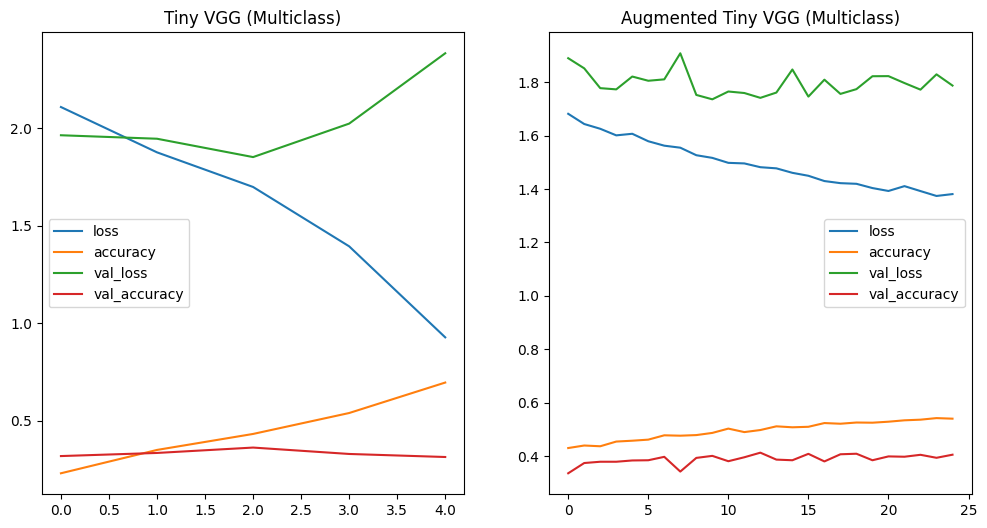

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_vgg_model_multiclass.history).plot(ax=axes[0], title="Tiny VGG (Multiclass)")
pd.DataFrame(history_vgg_model_multiclass_augmentation.history).plot(ax=axes[1], title="Augmented Tiny VGG (Multiclass)")

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_16.png)

### Making Predictions

In [8]:
img_height = 224
img_width = 224

# helper function to pre-process images for predictions
def prepare_image(file_name, img_height=img_height, img_width=img_width):
    # read in image
    img = tf.io.read_file(file_name)
    # image array => tensor
    img = tf.image.decode_image(img)
    # reshape to training size
    img = tf.image.resize(img, size=[img_height, img_width])
    # we don't need to normalize the image this is done by the model itself
    # img = img/255
    # add a dimension in front for batch size => shape=(1, 224, 224, 3)
    img = tf.expand_dims(img, axis=0)
    return img

# adapt plot function for multiclass predictions
def predict_and_plot_multi(model, file_name, class_names):
    # load the image and preprocess
    img = prepare_image(file_name)
    # run prediction
    prediction = model.predict(img)
    # check for multiclass
    if len(prediction[0]) > 1:
        # pick class with highest probability
        pred_class = class_names[tf.argmax(prediction[0])]
    else:
        # binary classifications only return 1 probability value
        pred_class = class_names[int(tf.round(prediction))]
    # plot image & prediction
    plt.imshow(mpimg.imread(file_name))
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

1/1 [==============================] - 0s 18ms/step


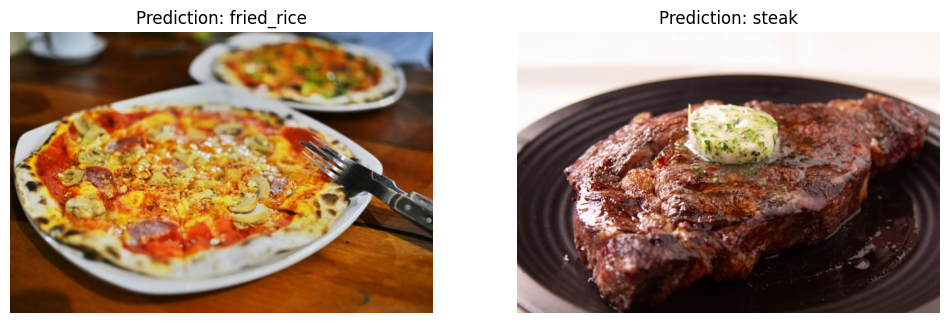

In [34]:
fig = plt.figure(figsize=(12, 6))
plot7 = fig.add_subplot(1, 2, 1)
pizza_image = predict_and_plot_multi(model=vgg_model_multiclass_augmentation, file_name=pizza_path, class_names=class_names)
plot8 = fig.add_subplot(1, 2, 2)
steak_image = predict_and_plot_multi(model=vgg_model_multiclass_augmentation, file_name=steak_path, class_names=class_names)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_17.png)

1/1 [==============================] - 0s 18ms/step


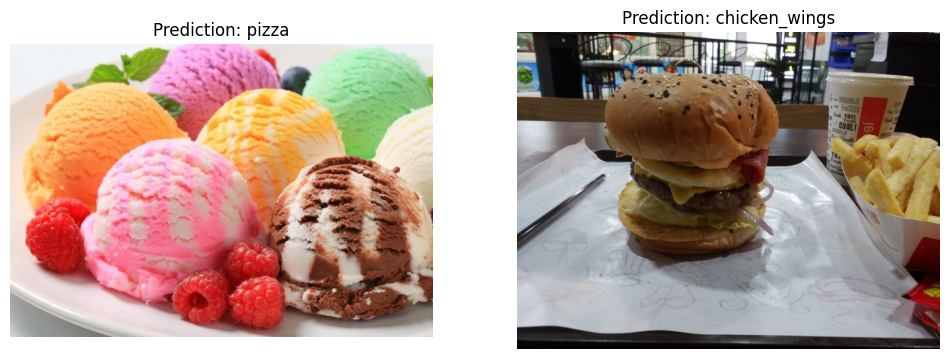

In [36]:
# a few more images to test with
ice_cream_path = "../assets/ice_cream.jpg"
hamburger_path = "../assets/hamburger.jpg"

fig = plt.figure(figsize=(12, 6))
plot7 = fig.add_subplot(1, 2, 1)
pizza_image = predict_and_plot_multi(model=vgg_model_multiclass_augmentation, file_name=ice_cream_path, class_names=class_names)
plot8 = fig.add_subplot(1, 2, 2)
steak_image = predict_and_plot_multi(model=vgg_model_multiclass_augmentation, file_name=hamburger_path, class_names=class_names)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_18.png)

![Convolutional Neural Networks](../assets/hmmmm.gif)

This pretty much sums up the `val_accuracy: 0.4048` value I gut during the training. With 10 I would get an ~ accuracy of `10%` if the model was guessing randomly. The training got us factor 4 improvement. But it is far from perfect.


The validation accuracy was still increasing - so if I kept training the model I would get better results. But the increase was very slow - it might take a long time. The validation loss was running away in the beginning. But adding image augmentations pulled it back down nicely. I have been experimenting with different augmentations and their effect ranged from good to terrible :) - there is still some room for improvement adding or adjusting augmentations.

The next thing - or maybe the first - would be to consolidate the dataset. Some of the images in it are terrible. They have plenty of clutter in the background. There is grilled salmon that looks like sushi. Or close-up chicken curry that could be a pizza. Removing some of those images, or preferably replacing them with higher quality images, will improve our model performance.

We could also check out the confuion matrix to see if there are classes that perform particularly bad. If there are we can concentrate our efforts on them. (see below - `sushi` and `ramen` seems to perform _OK_)


### Saving & Loading the Model

In [40]:
# save a model
vgg_model_multiclass_augmentation.save("../saved_models/vgg_model_multiclass_augmentation")

# INFO:tensorflow:Assets written to: ../saved_models/vgg_model_multiclass_augmentation/assets

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845ae350>, 140126193214576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845ae350>, 140126193214576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d4760>, 140126193214496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d4760>, 140126193214496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d65f0>, 140126589179968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d65f0>, 140126589179968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845f8580>, 140126193209456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845f8580>, 140126193209456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 10, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845fa350>, 140126193213136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 10, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845fa350>, 140126193213136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7184618250>, 140126193212576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7184618250>, 140126193212576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461a050>, 140126304165264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461a050>, 140126304165264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461bf10>, 140126193219696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461bf10>, 140126193219696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28090, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444dd50>, 140125886894112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28090, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444dd50>, 140125886894112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444fc10>, 140125886894352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444fc10>, 140125886894352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845ae350>, 140126193214576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845ae350>, 140126193214576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d4760>, 140126193214496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d4760>, 140126193214496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d65f0>, 140126589179968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845d65f0>, 140126589179968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845f8580>, 140126193209456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845f8580>, 140126193209456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 10, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845fa350>, 140126193213136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 10, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f71845fa350>, 140126193213136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7184618250>, 140126193212576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(16,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f7184618250>, 140126193212576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461a050>, 140126304165264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461a050>, 140126304165264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461bf10>, 140126193219696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718461bf10>, 140126193219696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28090, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444dd50>, 140125886894112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28090, 10), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444dd50>, 140125886894112), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444fc10>, 140125886894352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f718444fc10>, 140125886894352), {}).


INFO:tensorflow:Assets written to: ../saved_models/vgg_model_multiclass_augmentation/assets


INFO:tensorflow:Assets written to: ../saved_models/vgg_model_multiclass_augmentation/assets


In [ ]:
# load a trained model
loaded_model = tf.keras.models.load_model("../saved_models/vgg_model_multiclass_augmentation")

1/1 [==============================] - 0s 17ms/step


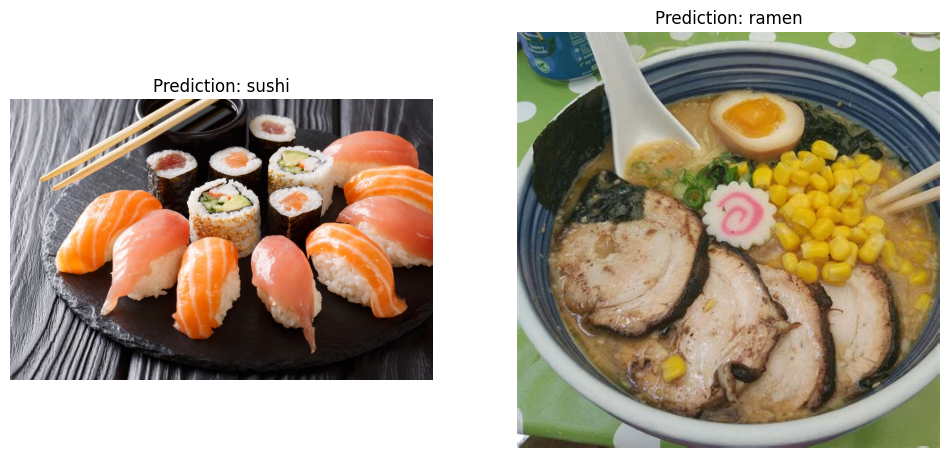

In [9]:
# test if the model was loaded successful
sushi_path = "../assets/sushi.jpg"
ramen_path = "../assets/ramen.jpg"

fig = plt.figure(figsize=(12, 6))
plot7 = fig.add_subplot(1, 2, 1)
pizza_image = predict_and_plot_multi(model=loaded_model, file_name=sushi_path, class_names=class_names)
plot8 = fig.add_subplot(1, 2, 2)
steak_image = predict_and_plot_multi(model=loaded_model, file_name=ramen_path, class_names=class_names)

![Convolutional Neural Networks](../assets/03_Tensorflow_Convolutional_Neural_Networks_19.png)

To fast forward -> Next try __Transfer Learning__